In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization.wcsaxes import SphericalCircle

import corner

import os

import requests

import pickle

import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
#sys.path.insert(1, '/Users/kellydouglass/Documents/Research/DESI/Targets/code/TF/')
from line_fits import param_invert, hyperfit_line

In [2]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

V0 = 2.5

# Data

## fuji

In [3]:
#tfuji = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits') # <-- CORI
tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


## SGA

In [4]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [5]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

# Separate the fuji data into center and off-center observations

In [6]:
tfuji['SKY_FIBER_DIST'] = 0.
tfuji['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in np.unique(tfuji['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tfuji['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tfuji['RA'][obs_idx], 
                             dec=tfuji['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tfuji['SKY_FIBER_DIST'][obs_idx] = sep2d
    tfuji['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

In [7]:
centers_boolean = tfuji['SKY_FIBER_DIST_R26'] < 0.1

fuji_centers = tfuji[centers_boolean]
fuji_axis = tfuji[~centers_boolean]

### Clean the fuji center observations

Only keep those with
 * DELTACHI2 > 25
 * ZWARN == 0

In [8]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

#### Are there any galaxies with multiple good center observations?

In [9]:
unique_ids, counts = np.unique(good_centers['SGA_ID'], return_counts=True)

print(unique_ids[counts > 1], counts[counts > 1])

 SGA_ID
-------
    848
   3727
   6443
  10959
  12318
  16649
  26199
  28451
  37543
  46327
    ...
1363936
1364394
1365198
1366241
1374698
1380792
1382772
1386484
1392414
1401610
1418640
Length = 175 rows [2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


### If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [10]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

# Coma cluster membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [11]:
# Data table #3 from Tully (2015)
hdu = fits.open('../Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

table3[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58


In [12]:
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigP'][Coma_row_t3][0]

In [13]:
# Data table #2 from Tully et al. (2013)
hdu = fits.open('../Tully13-Table2.fit')
table2 = Table(hdu[1].data)
hdu.close()

table2[:5]

_RAJ2000,_DEJ2000,N1,__Dist_,__DM_,__Err_,N2,GLON,GLAT,SGLON,SGLAT,GMT,__Bmag_,__Kmag_,__HV_,__GV_,__Vls_,__Vcmb_,__Vcmba_,sigma,__PV_,__PVa_,Group,Ng,_2M__,PGCb,GName,_2M,Simbad,NED,recno
float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,float64,int16,float64,float64,int32,int32,int32,int32,int32,int16,int32,int32,int16,int16,int16,int32,str10,str2,str6,str3,int32
266.404996,-28.936172,16,0.01,14.5,0.02,20,0.0,0.0,185.7861,42.3103,1,-6.0,-9.0,51,26,13,91,91,64,90,90,223,16,0,17223,Galaxy,2M,Simbad,NED,1
15.693346,36.392682,39,0.76,24.4,0.01,41,125.479,-26.423,322.2989,9.4579,2,3.4,0.68,-213,-49,17,-485,-484,156,-541,-547,222,39,0,2557,NGC0224,2M,Simbad,NED,2
149.896678,-12.831016,4,1.37,25.68,0.03,4,251.1365,32.2601,120.502,-42.5472,10,9.75,9.29,347,153,103,690,691,23,589,589,227,4,0,29128,NGC003109,2M,Simbad,NED,3
139.011477,52.840941,1,1.37,25.68,0.1,1,164.6636,42.8855,47.6118,-15.0125,10,13.75,11.5,-29,17,45,130,130,0,28,28,0,579,0,26142,UGC4879,2M,Simbad,NED,4
243.448636,54.37081,1,1.91,26.41,0.08,1,83.8788,44.4092,56.0935,40.37,10,16.69,12.9,-139,44,78,-121,-120,0,-262,-268,230,1,0,2801026,KKR25,2M,Simbad,NED,5


In [14]:
Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic')

group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

idx, d2d, d3d = Coma_coords.match_to_catalog_sky(group_coords)

V_Coma = table2['__HV_'][idx][0]

V_Coma

6899

## Calculate the projected distance between the Coma cluster and each SGA galaxy

In [15]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_Coma_angle = (R2t_Coma/(V_Coma/H0))*u.radian

In [16]:
SGA_coords = SkyCoord(SGA['RA'], SGA['DEC'], unit='deg')

sep = Coma_coords.separation(SGA_coords)

In [17]:
SGA_in_Coma1 = (sep < 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 3*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 3*sigma_Coma)

SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (sep < 3*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)
#SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)

SGA_in_Coma = SGA_in_Coma1 | SGA_in_Coma2

################################################################################
# Keep all observations of each galaxy that are within the Coma cluster
#-------------------------------------------------------------------------------
SGA_ID_in_Coma = SGA['SGA_ID'][SGA_in_Coma]

centers_inComa = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_Coma)]

axis_inComa = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_in_Coma)]
################################################################################

print('fuji galaxies in Coma with good center observations:', len(np.unique(centers_inComa['SGA_ID'])))
print('fuji off-center observations in Coma:', len(axis_inComa))

fuji galaxies in Coma with good center observations: 273
fuji off-center observations in Coma: 905


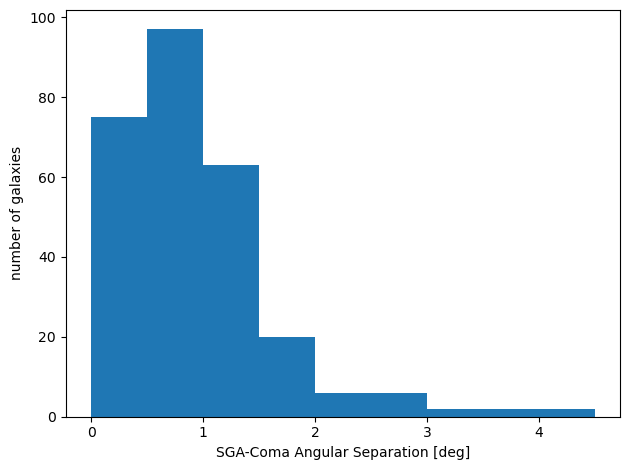

In [19]:
plt.figure(tight_layout=True)

plt.hist(sep[SGA_in_Coma].to_value('degree'), bins=np.arange(0, 5, 0.5))
#plt.hist(sep[np.in1d(SGA['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])].to_value('degree'), bins=np.arange(0, 5, 0.5))

plt.xlabel('SGA-Coma Angular Separation [deg]')
plt.ylabel('number of galaxies');

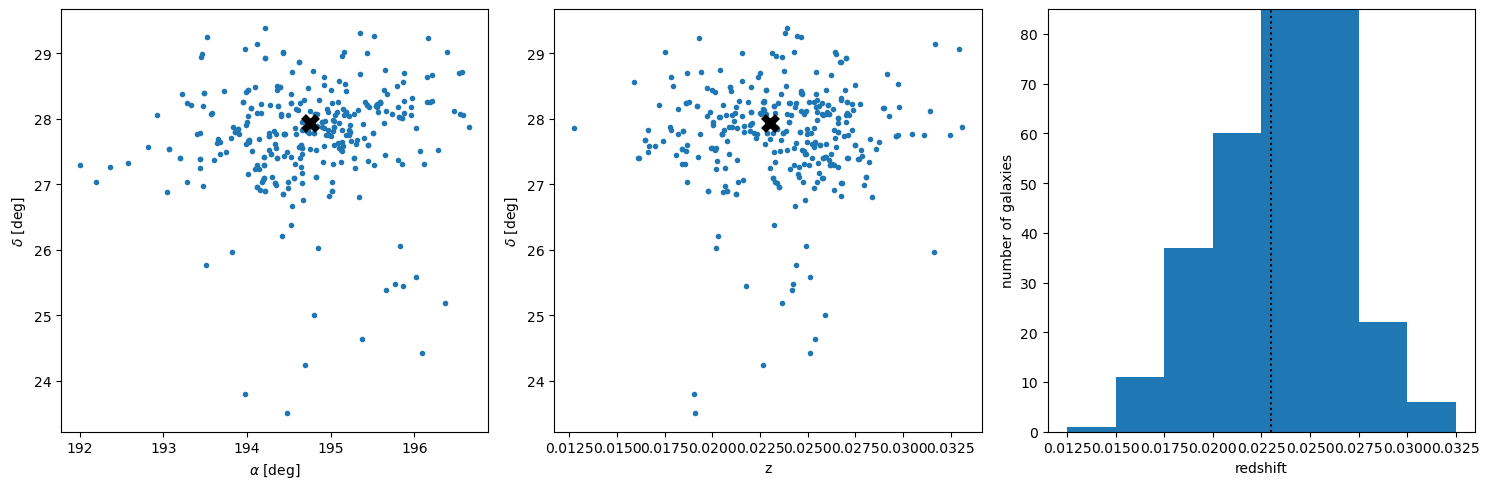

In [20]:
plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.plot(centers_inComa['TARGET_RA'], centers_inComa['TARGET_DEC'], '.')
# plt.plot(centers_inComa['TARGET_RA'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], 
#          centers_inComa['TARGET_DEC'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])],
#          'o')
plt.plot(Coma_coords.transform_to('icrs').ra.deg, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
plt.plot(centers_inComa['Z'], centers_inComa['TARGET_DEC'], '.')
# plt.plot(centers_inComa['Z'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], 
#          centers_inComa['TARGET_DEC'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])],
#          'o')
plt.plot(V_Coma/c, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
plt.hist(centers_inComa['Z'], bins=np.arange(0.0125, 0.035, 0.0025))
# plt.hist(centers_inComa['Z'][np.in1d(centers_inComa['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])], bins=np.arange(0.0125, 0.035, 0.0025))
plt.vlines(V_Coma/c, 0, 85, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=85);

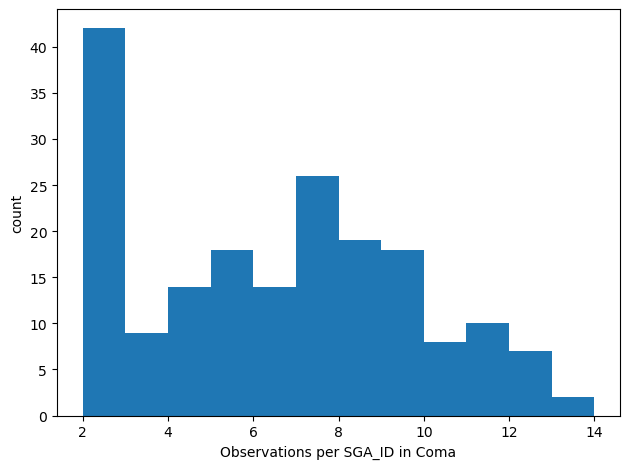

In [21]:
axis_SGAids, axis_counts = np.unique(axis_inComa['SGA_ID'], return_counts=True)
center_SGAids, center_counts = np.unique(centers_inComa['SGA_ID'], return_counts=True)

counts = []

for sga_id in SGA_ID_in_Coma:
    
    center_count = 0
    axis_count = 0
    
    if sga_id in center_SGAids:
        
        center_count = center_counts[center_SGAids == sga_id]
        
    if sga_id in axis_SGAids:
        
        axis_count = axis_counts[axis_SGAids == sga_id]
        
    count = center_count + axis_count
    
    if count > 1:
        
        counts.append(count)
        

plt.figure(tight_layout=True)

plt.hist(np.array(counts), bins=np.arange(2,15))

plt.xlabel('Observations per SGA_ID in Coma')
plt.ylabel('count');

# Calculate the rotational velocity

In [22]:
axis_inComa['SKY_FIBER_DIST'] = 0.
axis_inComa['SKY_FIBER_DIST_R26'] = 0.
axis_inComa['V_ROT'] = np.nan
axis_inComa['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_inComa['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_inComa['RA'][obs_idx], 
                             dec=axis_inComa['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_inComa['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_inComa['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_inComa['V_ROT'][obs_idx] = c*(axis_inComa['Z'][obs_idx] - z_center)
    axis_inComa['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_inComa['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

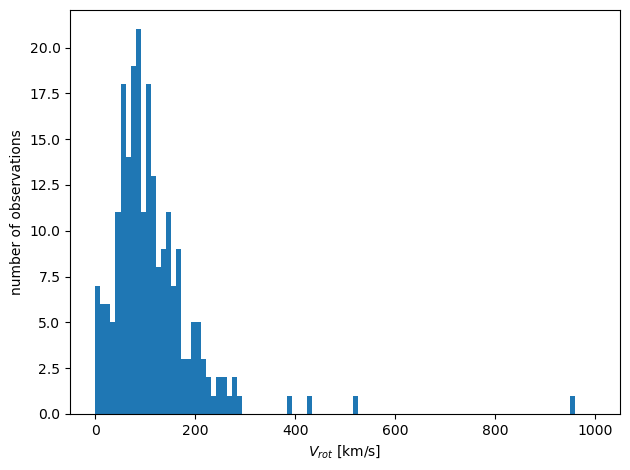

In [23]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_inComa['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for Coma galaxies suitable for calibrating the TFR

Requirements:
 * $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $\Delta V / V_{min} \leq 5$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

## Velocity cut

In [24]:
r0p3 = (axis_inComa['SKY_FIBER_DIST_R26'] > 0.3) & (axis_inComa['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = (np.abs(axis_inComa['V_ROT']) < 1000) & (np.abs(axis_inComa['V_ROT']) > 10)

good_axis_inComa = axis_inComa[r0p3 & Vgood]

print(len(good_axis_inComa), len(np.unique(good_axis_inComa['SGA_ID'])))

192 112


## Relative velocity cut

In [25]:
good_deltaV = np.ones(len(good_axis_inComa), dtype=bool)

for sga_id in np.unique(good_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_inComa['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_inComa['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_inComa['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_inComa['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_inComa['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_inComa['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_inComa['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            '''
            print(sga_id)
            print(diff_matrix_norm)
            print(1/v_norm_min.data)
            print(v_norm_max.data)
            print(good_axis_inComa[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
            ''';
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_inComa['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_inComa['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_inComa['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_inComa['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    '''
                    print(sga_id)
                    print(diff_matrix_norm)
                    print(good_axis_inComa[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
                    ''';
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

In [26]:
good_deltaV_axis_inComa = good_axis_inComa[good_deltaV]

print(len(good_deltaV_axis_inComa), len(np.unique(good_deltaV_axis_inComa['SGA_ID'])))

184 109


## Inclination angle cut

In [27]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

good_deltaV_axis_inComa['iSGA'] = -1

for i in range(len(good_deltaV_axis_inComa)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_inComa['SGA_ID'][i]]
    
    good_deltaV_axis_inComa['iSGA'][i] = sga_idx
    
good_deltaV_axis_inComa['cosi2'] = SGA['cosi2'][good_deltaV_axis_inComa['iSGA']]

In [28]:
i_min = 45. # degrees

cosi2_max = np.cos(i_min*np.pi/180.)**2

edge = good_deltaV_axis_inComa['cosi2'] <= cosi2_max

good_edge_axis_inComa = good_deltaV_axis_inComa[edge]

print(len(good_edge_axis_inComa), len(np.unique(good_edge_axis_inComa['SGA_ID'])))

149 90


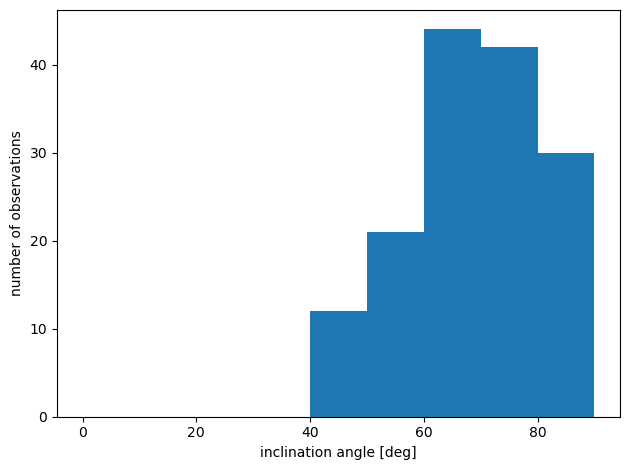

In [29]:
plt.figure(tight_layout=True)

plt.hist(np.arccos(np.sqrt(good_edge_axis_inComa['cosi2']))*180/np.pi, bins=np.linspace(0, 90, 10))

plt.xlabel('inclination angle [deg]')
plt.ylabel('number of observations');

## Morphology cut

In [30]:
good_edge_axis_inComa['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_inComa['iSGA']]

In [31]:
spirals = np.zeros(len(good_edge_axis_inComa), dtype=bool)

for i in range(len(good_edge_axis_inComa)):
    
    try:    
        if (good_edge_axis_inComa['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_inComa['MORPHTYPE'][i][:2] != 'S0'):
            spirals[i] = True
    except IndexError:
        print(good_edge_axis_inComa['MORPHTYPE'][i])

good_edge_spirals_axis_inComa = good_edge_axis_inComa[spirals]

print(len(good_edge_spirals_axis_inComa), len(np.unique(good_edge_spirals_axis_inComa['SGA_ID'])))

--
--
--
79 44


## Visual inspection cut

This removes any observations that are contaminated by foreground stars or other galaxies.

In [29]:
def get_cutout(targetid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'cache/coma_{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

cache/coma_39627776214435213.jpg exists.
INFO:spectra.py:291:read_spectra: iotime 4.317 sec to read spectra-sv3-bright-26004.fits at 2022-09-02T16:10:03.413145


TypeError: 'AxesSubplot' object is not subscriptable

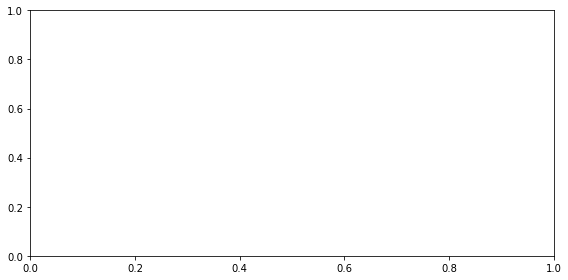

In [183]:
for sga_id in np.unique(good_edge_spirals_axis_inComa['SGA_ID']):
    
    tf_list = good_edge_spirals_axis_inComa[good_edge_spirals_axis_inComa['SGA_ID'] == sga_id]
    center_list = centers_inComa[centers_inComa['SGA_ID'] == sga_id]
    
    try:
        targetid = int(center_list['TARGETID'][0])
    except TypeError as err:
        print(err)
        # print(sga_galaxy['TARGETID'])
        continue
    
    ra, dec, z = float(SGA['RA'][SGA_dict[sga_id]]), float(SGA['DEC'][SGA_dict[sga_id]]), float(SGA['Z_DESI'][SGA_dict[sga_id]])
    
    # D26 in arcmin
    d26 = SGA['D26'][SGA_dict[sga_id]]
    
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
#     img_file = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig1 = plt.figure(figsize=(7,5))

    ax = fig1.add_subplot(111, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.set(xlabel='ra', ylabel='dec')
    ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted');

    # Add the location of the DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

    for tft in tf_list:
        ra, dec = tft['RA'], tft['DEC']
        
        edgecolor2 = 'orange'
#         if tft['Z'] > 0.05:
#             edgecolor2 = 'orange'
#         else:
#             edgecolor2 = 'lime'
        
        # Add the location of the DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)
        
        ax.text(ra, dec, str(tft['TARGETID']), transform=ax.get_transform('icrs'), color='white')
    
    fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
    fig1.savefig('cache/fuji_VI_cutouts/dist_{}.png'.format(sga_id), dpi=120)
    
    fig1.clear()
    plt.close(fig1)
    
    #----------------------------------------------------------------------------------
    # Get spectra
    #----------------------------------------------------------------------------------
    coadds = get_spectra_for_sga(good_edge_spirals_axis_inComa, sga_id)
    n = coadds.num_spectra()

    fig2, axes = plt.subplots(n,1, figsize=(8,4*n), sharex=True, sharey=True, tight_layout=True)

    for i in range(n):
        wave = coadds.wave['brz']
        flux = coadds.flux['brz'][i]
        smoothed = gaussian_filter1d(flux, 7)

        ax = axes[i]
        ax.plot(wave, smoothed, label='TARGETID: {}'.format(coadds.fibermap['TARGETID'][i]))
        ax.set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
        if i+1 == n:
            ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')

        ax.legend(loc='upper right', fontsize=10)
    
    # figure = PdfPages('cache/DM_cutouts/dist_{}.pdf'.format(sga_id))
    # figure.savefig(fig1, dpi = 300)
    # figure.savefig(fig2, dpi = 120)
    # figure.close()
    
    break

In [32]:
VI_remove = Table.read('fuji_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(good_edge_spirals_axis_inComa), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (good_edge_spirals_axis_inComa['TARGETID'] == targetid)
    
VI_good_edge_spirals_axis_inComa = good_edge_spirals_axis_inComa[~remove_targets]

print(len(VI_good_edge_spirals_axis_inComa), len(np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID'])))

79 44


# Coma TFR

## Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [33]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

weights = 1./(VI_good_edge_spirals_axis_inComa['V_ROT_ERR']**2)

for sga_id in np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = VI_good_edge_spirals_axis_inComa['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [34]:
# Make a catalog of just those galaxies with velocities
SGA_TF = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

# Christoph_removed = np.in1d(SGA_TF['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])

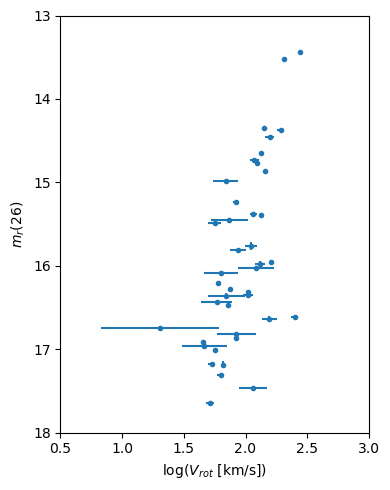

In [35]:
plt.figure(figsize=(4,5), tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR'], 
             fmt='.')
# plt.errorbar(np.log10(SGA_TF['V_0p33R26'][Christoph_removed]), 
#              SGA_TF['R_MAG_SB26'][Christoph_removed], 
#              xerr=0.434*SGA_TF['V_0p33R26_err'][Christoph_removed]/SGA_TF['V_0p33R26'][Christoph_removed],
#              yerr=SGA_TF['R_MAG_SB26_ERR'][Christoph_removed], 
#              fmt='.')

plt.xlim([0.5, 3])
plt.ylim([18, 13])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$');

## Remove dwarf galaxies

This is to mimic the selection criteria used in the Cosmicflows-4 calibration, and is only possible after a full calibration has been done.  This is therefore an iterative process.

### First, calculate the absolute magnitudes for the galaxies based on the current TF calibration

\begin{equation}
  M_r = a(\log \left( V(0.33R_{26}) \right) - V_0) + b
\end{equation}
where
* $a = -7.46^{+1.07}_{-1.65} = -7.46\pm 1.58$ (from `Coma-Fuji-ITFR_KAD.ipynb`)
* $b = -22.27\pm 0.24$ (from `fuji_zero-point_ITFR_KAD.ipynb`)

(Updated 8/9/23)

In [36]:
our_slope = -7.46
our_slope_err = 1.58

our_ZP = -22.27
our_ZP_err = 0.24

SGA_TF['R_ABSMAG_SB26'] = our_slope*(np.log10(SGA_TF['V_0p33R26']) - V0) + our_ZP

In [37]:
N_samples = 10000

temp_infile = open('cov_ab_fuji_zero-point_ITFR_KAD.pickle', 'rb')
cov_ab = pickle.load(temp_infile)
temp_infile.close()

rng = np.random.default_rng()

#m_random = rng.normal(our_slope, our_slope_err, size=N_samples)
#b_random = rng.normal(our_ZP, our_ZP_err, size=N_samples)
m_random, b_random = rng.multivariate_normal([our_slope, our_ZP], cov_ab, N_samples).T

SGA_TF['R_ABSMAG_SB26_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m_random*(np.log10(v_random) - V0) + b_random
    
    SGA_TF['R_ABSMAG_SB26_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_494149/3868608957.py:19: RuntimeWarning: invalid value encountered in log10
  Ms = m_random*(np.log10(v_random) - V0) + b_random


### Filter out dwarf galaxies

Those with $M_r > -17$

In [38]:
dwarfs = (SGA_TF['R_ABSMAG_SB26'] - SGA_TF['R_ABSMAG_SB26_err']) > -17

SGA_TF_bright = SGA_TF[~dwarfs]

print(np.sum(dwarfs))

1


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these first "dwarf" galaxies, the best-fit parameters for our TFR are
* $-7.57^{+1.19}_{-1.61} = -7.57\pm 1.61$ (from this notebook)
* $-22.29\pm 0.27$ (from `fuji_zero-point_ITFR_nodwarf_KAD.ipynb`)

(Updated 8/15/23)

In [47]:
our_bright_slope = -7.57
our_bright_slope_err = 1.61

our_bright_ZP = -22.29
our_bright_ZP_err = 0.27

SGA_TF['R_ABSMAG_SB26_bright'] = our_bright_slope*(np.log10(SGA_TF['V_0p33R26']) - V0) + our_bright_ZP

In [48]:
temp_infile = open('cov_ab_fuji_zero-point_ITFR_nodwarf1_KAD.pickle', 'rb')
cov_ab_bright = pickle.load(temp_infile)
temp_infile.close()

#m2_random = rng.normal(our_bright_slope, our_bright_slope_err, size=N_samples)
#b2_random = rng.normal(our_bright_ZP, our_bright_ZP_err, size=N_samples)
m2_random, b2_random = rng.multivariate_normal([our_bright_slope, our_bright_ZP], cov_ab_bright, N_samples).T

SGA_TF['R_ABSMAG_SB26_bright_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m2_random*(np.log10(v_random) - V0) + b2_random
    
    SGA_TF['R_ABSMAG_SB26_bright_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_494149/3343526711.py:15: RuntimeWarning: invalid value encountered in log10
  Ms = m2_random*(np.log10(v_random) - V0) + b2_random


In [49]:
dwarfs2 = (SGA_TF['R_ABSMAG_SB26_bright'] - SGA_TF['R_ABSMAG_SB26_bright_err']) > -17

SGA_TF_bright2 = SGA_TF[~dwarfs2]

print(np.sum(dwarfs2))

1


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these second "dwarf" galaxies, the best-fit parameters for our TFR are
* $-7.68^{+1.15}_{-1.64} = -7.68\pm 1.65$ (from the second iteration in this notebook)
* $-22.33\pm 0.28$ (from the second iteration in `fuji_zero-point_ITFR_nodwarf_KAD.ipynb`)

In [60]:
our_bright_slope2 = -7.68
our_bright_slope2_err = 1.65

our_bright_ZP2 = -22.33
our_bright_ZP2_err = 0.28

SGA_TF['R_ABSMAG_SB26_bright2'] = our_bright_slope2 * (np.log10(SGA_TF['V_0p33R26']) - V0) + our_bright_ZP2

In [61]:
temp_infile = open('cov_ab_fuji_zero-point_ITFR_nodwarf2_KAD.pickle', 'rb')
cov_ab_bright2 = pickle.load(temp_infile)
temp_infile.close()

#m3_random = rng.normal(our_bright_slope2, our_bright_slope2_err, size=N_samples)
#b3_random = rng.normal(our_bright_ZP2, our_bright_ZP2_err, size=N_samples)
m3_random, b3_random = rng.multivariate_normal([our_bright_slope2, our_bright_ZP2], cov_ab_bright2, N_samples).T

SGA_TF['R_ABSMAG_SB26_bright2_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m3_random * (np.log10(v_random) - V0) + b3_random
    
    SGA_TF['R_ABSMAG_SB26_bright2_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_2247846/3160646556.py:15: RuntimeWarning: invalid value encountered in log10
  Ms = m3_random * (np.log10(v_random) - V0) + b3_random


In [62]:
dwarfs3 = (SGA_TF['R_ABSMAG_SB26_bright2'] - SGA_TF['R_ABSMAG_SB26_bright2_err']) > -17

SGA_TF_bright3 = SGA_TF[~dwarfs3]

print(np.sum(dwarfs3))

3


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these third "dwarf" galaxies, the best-fit parameters for our TFR are
* $-8.55^{+1.40}_{-1.98}$ (from the third iteration in this notebook)
* $-18.19\pm 0.64$ (from the third iteration in `fuji_zero-point_nodwarf_KAD.ipynb`)

In [80]:
our_bright_slope3 = -8.55
our_bright_slope3_err = 1.87

our_bright_ZP3 = -18.19
our_bright_ZP3_err = 0.64

SGA_TF['R_ABSMAG_SB26_bright3'] = our_bright_slope3 * (np.log10(SGA_TF['V_0p33R26']) - 2.) + our_bright_ZP3

In [81]:
m4_random = rng.normal(our_bright_slope3, our_bright_slope3_err, size=N_samples)
b4_random = rng.normal(our_bright_ZP3, our_bright_ZP3_err, size=N_samples)

SGA_TF['R_ABSMAG_SB26_bright3_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m4_random * (np.log10(v_random) - 2.) + b4_random
    
    SGA_TF['R_ABSMAG_SB26_bright3_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_3745/1383774645.py:10: RuntimeWarning: invalid value encountered in log10
  Ms = m4_random * (np.log10(v_random) - 2.) + b4_random


In [82]:
dwarfs4 = (SGA_TF['R_ABSMAG_SB26_bright3'] - SGA_TF['R_ABSMAG_SB26_bright3_err']) > -17

SGA_TF_bright4 = SGA_TF[~dwarfs4]

print(np.sum(dwarfs4))

8


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these fourth "dwarf" galaxies, the best-fit parameters for our TFR are
* $-8.95^{+1.64}_{-2.25}$ (from the fourth iteration in this notebook)
* $-18.06\pm 0.72$ (from the fourth iteration in `fuji_zero-point_nodwarf_KAD.ipynb`)

In [100]:
our_bright_slope4 = -8.95
our_bright_slope4_err = 2.10

our_bright_ZP4 = -18.06
our_bright_ZP4_err = 0.72

SGA_TF['R_ABSMAG_SB26_bright4'] = our_bright_slope4 * (np.log10(SGA_TF['V_0p33R26']) - 2.) + our_bright_ZP4

In [101]:
m5_random = rng.normal(our_bright_slope4, our_bright_slope4_err, size=N_samples)
b5_random = rng.normal(our_bright_ZP4, our_bright_ZP4_err, size=N_samples)

SGA_TF['R_ABSMAG_SB26_bright4_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m5_random * (np.log10(v_random) - 2.) + b5_random
    
    SGA_TF['R_ABSMAG_SB26_bright4_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_3745/4104580723.py:10: RuntimeWarning: invalid value encountered in log10
  Ms = m5_random * (np.log10(v_random) - 2.) + b5_random


In [102]:
dwarfs5 = (SGA_TF['R_ABSMAG_SB26_bright4'] - SGA_TF['R_ABSMAG_SB26_bright4_err']) > -17

SGA_TF_bright5 = SGA_TF[~dwarfs5]

print(np.sum(dwarfs5))

10


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these fifth "dwarf" galaxies, the best-fit parameters for our TFR are
* $-9.68^{+1.89}_{-2.94}$ (from the fifth iteration in this notebook)
* $-17.80\pm 0.97$ (from the fifth iteration in `fuji_zero-point_nodwarf_KAD.ipynb`)

In [111]:
our_bright_slope5 = -9.68
our_bright_slope5_err = 2.82

our_bright_ZP5 = -17.80
our_bright_ZP5_err = 0.97

SGA_TF['R_ABSMAG_SB26_bright5'] = our_bright_slope5 * (np.log10(SGA_TF['V_0p33R26']) - 2.) + our_bright_ZP5

In [112]:
m6_random = rng.normal(our_bright_slope5, our_bright_slope5_err, size=N_samples)
b6_random = rng.normal(our_bright_ZP5, our_bright_ZP5_err, size=N_samples)

SGA_TF['R_ABSMAG_SB26_bright5_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m6_random * (np.log10(v_random) - 2.) + b6_random
    
    SGA_TF['R_ABSMAG_SB26_bright5_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_3745/1876344261.py:10: RuntimeWarning: invalid value encountered in log10
  Ms = m6_random * (np.log10(v_random) - 2.) + b6_random


In [113]:
dwarfs6 = (SGA_TF['R_ABSMAG_SB26_bright5'] - SGA_TF['R_ABSMAG_SB26_bright5_err']) > -17

SGA_TF_bright6 = SGA_TF[~dwarfs6]

print(np.sum(dwarfs6))

10


## Fit the ITFR using `hyperfit`

### First iteration

Using `dwarfs` sample

In [39]:
bounds = ((-1000.0, 1000.0), (-10.0, 10.0), (1.0e-5, 500.0))

w0, w1, sig_w, cov_w, mcmc_samples, hf = hyperfit_line(SGA_TF_bright['R_MAG_SB26'], 
                                                       np.log10(SGA_TF_bright['V_0p33R26']) - V0, 
                                                       SGA_TF_bright['R_MAG_SB26_ERR'], 
                                                       0.434*SGA_TF_bright['V_0p33R26_err']/SGA_TF_bright['V_0p33R26'], 
                                                       bounds)

     fun: -54.735531673823154
     jac: array([-0.09483401,  0.02979021,  0.00069349])
 message: 'Optimization terminated successfully.'
    nfev: 3673
     nit: 80
 success: True
       x: array([0.18899485, 1.48707258, 0.14145529])


100%|██████████| 1000/1000 [00:00<00:00, 2112.57it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [89.25617437 91.12597643 51.0048094 ] / 4556.29882142269


100%|██████████| 1000/1000 [00:00<00:00, 2153.43it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [95.37747381 97.86154742 53.45261693] / 4893.077371061172


100%|██████████| 1000/1000 [00:00<00:00, 2081.27it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [106.67630182 107.71913312  49.50606004] / 5385.956655933436


100%|██████████| 1000/1000 [00:00<00:00, 2049.27it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [145.92422624 147.79780059  44.80445047] / 7389.890029621432


100%|██████████| 1000/1000 [00:00<00:00, 2140.96it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [162.38265502 162.07939638  53.41648815] / 8119.13275112007


100%|██████████| 1000/1000 [00:00<00:00, 2116.73it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [174.16692431 177.83638647  60.81621163] / 8891.819323716503


100%|██████████| 1000/1000 [00:00<00:00, 2071.68it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [210.04596407 213.96022992  63.90621168] / 10698.011495909377


100%|██████████| 1000/1000 [00:00<00:00, 2037.53it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [214.4591412  218.65063622  69.30445634] / 10932.53181113502


100%|██████████| 1000/1000 [00:00<00:00, 2083.97it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [204.87048356 212.69643463  71.52553049] / 10634.821731436567


100%|██████████| 1000/1000 [00:00<00:00, 2109.89it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [211.1725039  223.14091105  69.43590212] / 11157.045552646403


100%|██████████| 1000/1000 [00:00<00:00, 2035.08it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [188.00314347 202.82482915  62.81675588] / 10141.24145732888


100%|██████████| 1000/1000 [00:00<00:00, 2062.58it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [220.38591242 242.30370927  65.99014044] / 12115.18546332971


100%|██████████| 1000/1000 [00:00<00:00, 2167.27it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [195.7801903  212.9737697   65.38245947] / 10648.688484955128


100%|██████████| 1000/1000 [00:00<00:00, 2109.16it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [187.12144345 200.23416847  68.76833704] / 10011.708423473037


100%|██████████| 1000/1000 [00:00<00:00, 2112.93it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [221.73990306 245.98795256  66.0196139 ] / 12299.397628245682


100%|██████████| 1000/1000 [00:00<00:00, 2098.22it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [223.22655917 249.99186277  64.21301946] / 12499.593138498552


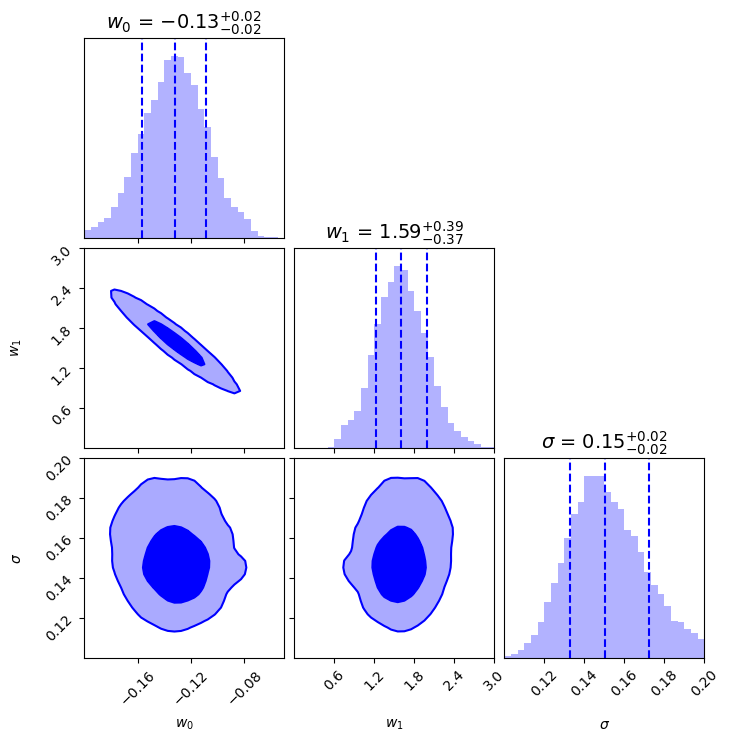

In [41]:
fig = corner.corner(mcmc_samples.T, bins=30, smooth=1,
                    range=[[-0.2, -0.05], [0, 3], [0.1, 0.2]],   # Range for w0, w1, sigma. Adjust as needed.
                    labels=['$w_0$', '$w_1$', r'$\sigma$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Coma w/o dwarfs, 1st iteration'},
                    title_kwargs={"fontsize": 14})

In [42]:
a_itfr, b_itfr, cov_itfr = param_invert(w0, w1, cov_w[:2,:2])

print(f'         w0: {w0:.3f} +/- {np.sqrt(cov_w[0,0]):.3f}')
print(f'         w1:  {w1:.2f}  +/- {np.sqrt(cov_w[1,1]):.2f}')
print(f'      slope: {a_itfr:.2f}  +/- {np.sqrt(cov_itfr[0,0]):.2f}')
print(f'y-intercept: {b_itfr:.2f}  +/- {np.sqrt(cov_itfr[1,1]):.2f}')

         w0: -0.132 +/- 0.024
         w1:  1.59  +/- 0.38
      slope: -7.57  +/- 1.61
y-intercept: 12.05  +/- 0.83


In [43]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples = np.zeros(mcmc_samples.shape)

tfr_mcmc_samples[0] = 1./mcmc_samples[0]
tfr_mcmc_samples[1] = -mcmc_samples[1]/mcmc_samples[0]
tfr_mcmc_samples[2] = mcmc_samples[2]

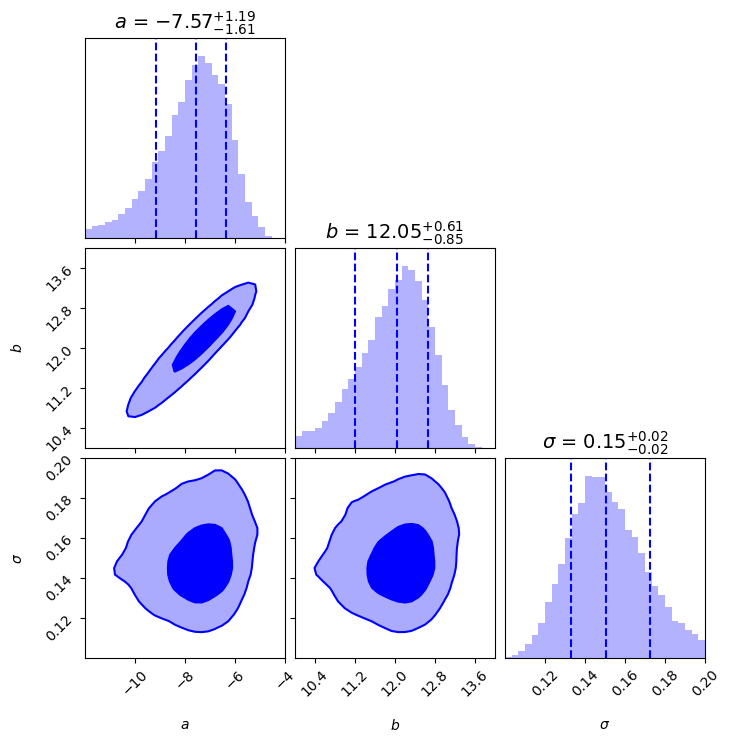

In [45]:
fig = corner.corner(tfr_mcmc_samples.T, bins=30, smooth=1,
                    range=[[-12, -4], [10, 14], [0.1, 0.2]],   # Range for a, b, sigma. Adjust as needed.
                    labels=['$a$', '$b$', r'$\sigma$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Coma w/o dwarfs, 1st iteration'},
                    title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

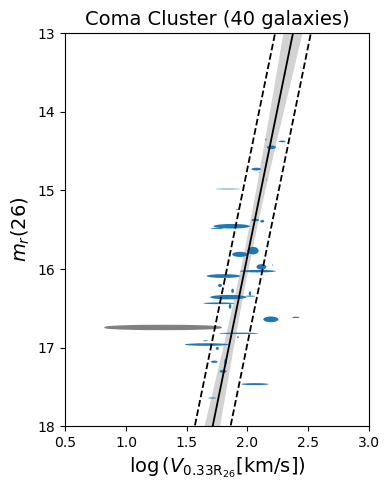

In [46]:
sigmas = hf.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = a_itfr * (xvals - V0) + b_itfr

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals - V0, tfr_mcmc_samples[0]) + tfr_mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF_bright['V_0p33R26']), SGA_TF_bright['R_MAG_SB26']]
x_err = 0.434*SGA_TF_bright['V_0p33R26_err']/SGA_TF_bright['V_0p33R26']
y_err = SGA_TF_bright['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Removed galaxies
data_removed = [np.log10(SGA_TF['V_0p33R26'][dwarfs]), SGA_TF['R_MAG_SB26'][dwarfs]]
x_err_removed = 0.434*SGA_TF['V_0p33R26_err'][dwarfs]/SGA_TF['V_0p33R26'][dwarfs]
y_err_removed = SGA_TF['R_MAG_SB26_ERR'][dwarfs]
corr_xy_removed = np.zeros_like(x_err_removed)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
ells_removed = [
    Ellipse(
        xy=[data_removed[0][i], data_removed[1][i]],
        width=2*y_err_removed[i],
        height=2*x_err_removed[i],
        angle=np.rad2deg(np.arccos(corr_xy_removed[i])),
    )
    for i in range(len(data_removed[0]))
]

# Make the plot
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_edgecolor('None')
for i, e in enumerate(ells_removed):
    ax.add_artist(e)
    e.set_color('gray')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.plot(xvals - hf.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals + hf.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF_bright)), fontsize = 14)
ax.set_xlim(0.5, 3)
ax.set_ylim(18, 13);

#plt.savefig('../../Figures/SV/fuji_Coma_TFR_20221013.png', dpi=150);

### Second iteration

Using `dwarfs2` sample

In [53]:
w0_2, w1_2, sig_w_2, cov_w_2, mcmc_samples2, hf2 = hyperfit_line(SGA_TF_bright2['R_MAG_SB26'], 
                                                                 np.log10(SGA_TF_bright2['V_0p33R26']) - V0, 
                                                                 SGA_TF_bright2['R_MAG_SB26_ERR'], 
                                                                 0.434*SGA_TF_bright2['V_0p33R26_err']/SGA_TF_bright2['V_0p33R26'], 
                                                                 bounds)

     fun: -55.940954060568075
     jac: array([-0.03368115, -0.00013003,  0.00133511])
 message: 'Optimization terminated successfully.'
    nfev: 6561
     nit: 144
 success: True
       x: array([0.17672587, 1.42883097, 0.14469453])


100%|██████████| 1000/1000 [00:00<00:00, 1959.70it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [81.13934173 81.13242454 41.57695897] / 4056.9670867128757


100%|██████████| 1000/1000 [00:00<00:00, 1873.61it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [109.5224245  110.29537338  46.5997697 ] / 5514.768669249224


100%|██████████| 1000/1000 [00:00<00:00, 1936.38it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [132.08713919 132.10398756  59.07651707] / 6605.199378003683


100%|██████████| 1000/1000 [00:00<00:00, 1973.35it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [202.65400339 202.78017092  86.16935052] / 10139.00854612426


100%|██████████| 1000/1000 [00:00<00:00, 1958.07it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [204.86099042 211.56434482 110.10361489] / 10578.21724112344


100%|██████████| 1000/1000 [00:00<00:00, 1826.21it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [171.51276945 176.42135316 109.20248256] / 8821.067658179649


100%|██████████| 1000/1000 [00:00<00:00, 1793.19it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [204.67010647 206.94579011  98.66922246] / 10347.289505661782


100%|██████████| 1000/1000 [00:00<00:00, 1879.43it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [212.88579201 220.57137289  94.25993662] / 11028.568644481002


100%|██████████| 1000/1000 [00:00<00:00, 1889.45it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [178.75422068 192.89230649  91.46179837] / 9644.61532456246


100%|██████████| 1000/1000 [00:00<00:00, 1897.96it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [163.36549273 169.16568832  76.91703573] / 8458.284416200166


100%|██████████| 1000/1000 [00:00<00:00, 1934.17it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [178.8739205  180.99970471  55.89753326] / 9049.98523561226


100%|██████████| 1000/1000 [00:00<00:00, 1843.31it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [188.95016181 191.85691996  55.47611482] / 9592.845998187633


100%|██████████| 1000/1000 [00:00<00:00, 1942.09it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [201.61272928 203.14465755  53.50155766] / 10157.232877504814


100%|██████████| 1000/1000 [00:00<00:00, 1867.15it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [196.39281849 198.9774516   60.6553581 ] / 9948.872579768662


100%|██████████| 1000/1000 [00:00<00:00, 1959.21it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [192.20403188 194.99369665  65.18126944] / 9749.684832379338


100%|██████████| 1000/1000 [00:00<00:00, 1963.32it/s]

Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [199.34908397 202.10988411  68.20628244] / 10105.49420531862


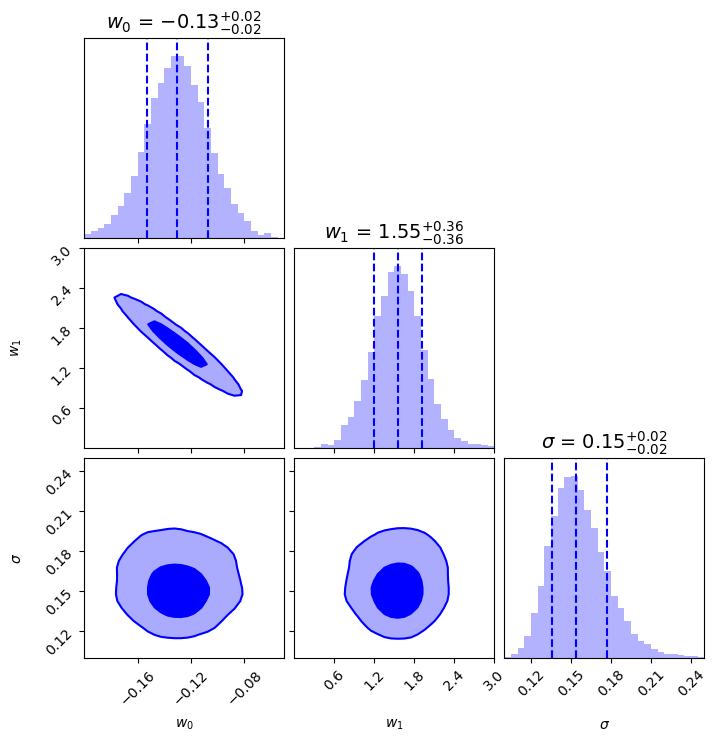

In [54]:
fig = corner.corner(mcmc_samples2.T, bins=30, smooth=1,
                    range=[[-0.2, -0.05], [0, 3], [0.1, 0.25]],   # Range for w0, w1, sigma. Adjust as needed.
                    labels=['$w_0$', '$w_1$', r'$\sigma$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Coma w/o dwarfs, 2nd iteration'},
                    title_kwargs={"fontsize": 14})

In [55]:
a2, b2, cov2 = param_invert(w0_2, w1_2, cov_w_2[:2,:2])

print(f'         w0: {w0_2:.3f} +/- {np.sqrt(cov_w_2[0,0]):.3f}')
print(f'         w1:  {w1_2:.2f}  +/- {np.sqrt(cov_w_2[1,1]):.2f}')
print(f'      slope: {a2:.2f}  +/- {np.sqrt(cov2[0,0]):.2f}')
print(f'y-intercept: {b2:.2f}  +/- {np.sqrt(cov2[1,1]):.2f}')

         w0: -0.130 +/- 0.024
         w1:  1.55  +/- 0.38
      slope: -7.68  +/- 1.65
y-intercept: 11.94  +/- 0.86


In [56]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples2 = np.zeros(mcmc_samples2.shape)

tfr_mcmc_samples2[0] = 1./mcmc_samples2[0]
tfr_mcmc_samples2[1] = -mcmc_samples2[1]/mcmc_samples2[0]
tfr_mcmc_samples2[2] = mcmc_samples2[2]

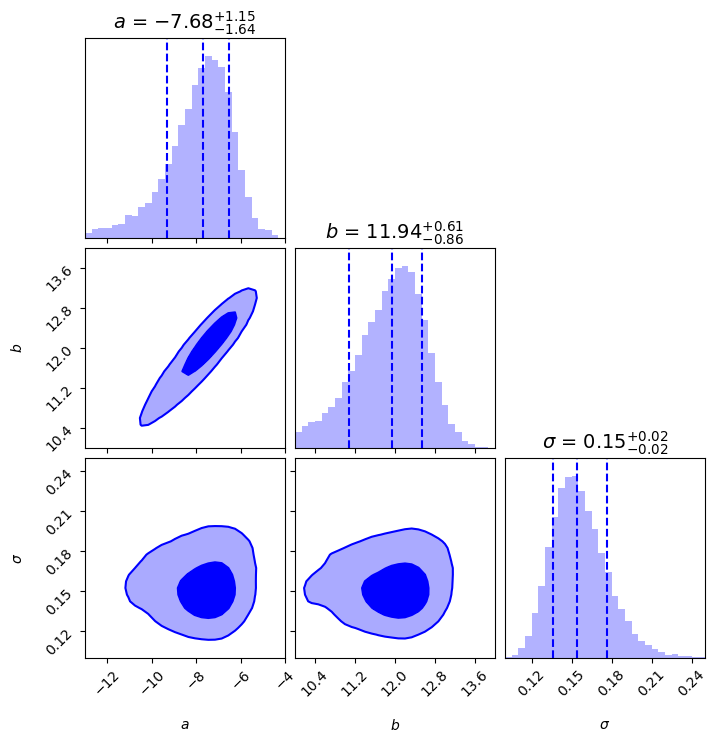

In [57]:
fig = corner.corner(tfr_mcmc_samples2.T, bins=30, smooth=1,
             range=[[-13, -4], [10, 14], [0.1, 0.25]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma w/o dwarfs, 2nd iteration'},
             title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

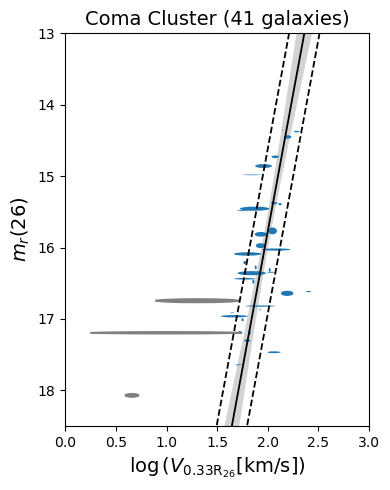

In [59]:
sigmas = hf2.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = a2 * (xvals - V0) + b2

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals - V0, tfr_mcmc_samples2[0]) + tfr_mcmc_samples2[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF_bright2['V_0p33R26']), SGA_TF_bright2['R_MAG_SB26']]
x_err = 0.434*SGA_TF_bright2['V_0p33R26_err']/SGA_TF_bright2['V_0p33R26']
y_err = SGA_TF_bright2['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Removed galaxies
data_removed = [np.log10(SGA_TF['V_0p33R26'][dwarfs2]), SGA_TF['R_MAG_SB26'][dwarfs2]]
x_err_removed = 0.434*SGA_TF['V_0p33R26_err'][dwarfs2]/SGA_TF['V_0p33R26'][dwarfs2]
y_err_removed = SGA_TF['R_MAG_SB26_ERR'][dwarfs2]
corr_xy_removed = np.zeros_like(x_err_removed)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
ells_removed = [
    Ellipse(
        xy=[data_removed[0][i], data_removed[1][i]],
        width=2*y_err_removed[i],
        height=2*x_err_removed[i],
        angle=np.rad2deg(np.arccos(corr_xy_removed[i])),
    )
    for i in range(len(data_removed[0]))
]

# Make the plot
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_edgecolor('None')
for i, e in enumerate(ells_removed):
    ax.add_artist(e)
    e.set_color('gray')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.plot(xvals - hf2.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals + hf2.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF_bright2)), fontsize = 14)
ax.set_xlim(0, 3)
ax.set_ylim(18.5, 13);

#plt.savefig('../../Figures/SV/fuji_Coma_TFR_20221013.png', dpi=150)

### Third iteration

Using `dwarfs3` sample

#### Create covariance matrix for `hyperfit`

In [70]:
Ndata = len(SGA_TF_bright3)
cov = np.empty((2, 2, Ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i in range(Ndata):
    cov[:,:,i] = np.array([[(0.434*SGA_TF_bright3['V_0p33R26_err'][i]/SGA_TF_bright3['V_0p33R26'][i])**2, 0.], 
                           [0., SGA_TF_bright3['R_MAG_SB26_ERR'][i]**2]])

#### Create `hyperfit` object

In [71]:
hf = LinFit([np.log10(SGA_TF_bright3['V_0p33R26']) - 2., SGA_TF_bright3['R_MAG_SB26']], cov)

#### Run MCMC to fit TFR

In [72]:
bounds3 = ((-10.0, 10.0), (-1000.0, 1000.0), (1.0e-5, 500.0))

mcmc_samples3, mcmc_lnlike3 = hf.emcee(bounds3, verbose=True)

print(np.mean(mcmc_samples3, axis=1), np.std(mcmc_samples3, axis=1))

     fun: -53.31782360193888
     jac: array([-0.00239524,  0.00775842, -0.04957172])
 message: 'Optimization terminated successfully.'
    nfev: 6901
     nit: 152
 success: True
       x: array([1.78805074, 0.20446296, 0.14349157])


100%|██████████| 1000/1000 [00:00<00:00, 2094.61it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [68.56160146 67.64403952 46.60340999] / 3428.08007296617


100%|██████████| 1000/1000 [00:00<00:00, 2005.24it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [99.26512865 95.95179907 50.07532064] / 4963.256432661015


100%|██████████| 1000/1000 [00:00<00:00, 2145.01it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [116.19538145 115.08285237  59.66780607] / 5809.769072723758


100%|██████████| 1000/1000 [00:00<00:00, 2163.07it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [113.59585234 111.44427506  52.95566869] / 5679.792616848697


100%|██████████| 1000/1000 [00:00<00:00, 2146.22it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [118.17381878 119.02153667  56.25175319] / 5951.0768336989395


100%|██████████| 1000/1000 [00:00<00:00, 2120.38it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [107.62139397 107.31947129  49.45944824] / 5381.069698574364


100%|██████████| 1000/1000 [00:00<00:00, 2256.54it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [123.38168315 122.69617626  54.48107849] / 6169.084157412179


100%|██████████| 1000/1000 [00:00<00:00, 2167.26it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [127.93796139 126.50954067  71.72451244] / 6396.898069727015


100%|██████████| 1000/1000 [00:00<00:00, 2203.75it/s]

Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [128.673163   127.3851263   71.18178396] / 6433.6581499492795
[-8.86975757 15.85320082  1.37260715] [1.86618276 0.24105652 0.35367101]


#### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and $m_r$, and the color given by the best-fit scatter parameter $\sigma_i$.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [73]:
a3, b3, sig3    = np.median(mcmc_samples3, axis=1)
da3, db3, dsig3 = np.std(mcmc_samples3, axis=1)

for val, err in zip((a3, b3, sig3), (da3, db3, dsig3)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -8.55 +/- 1.87
 15.85 +/- 0.24
  1.30 +/- 0.35


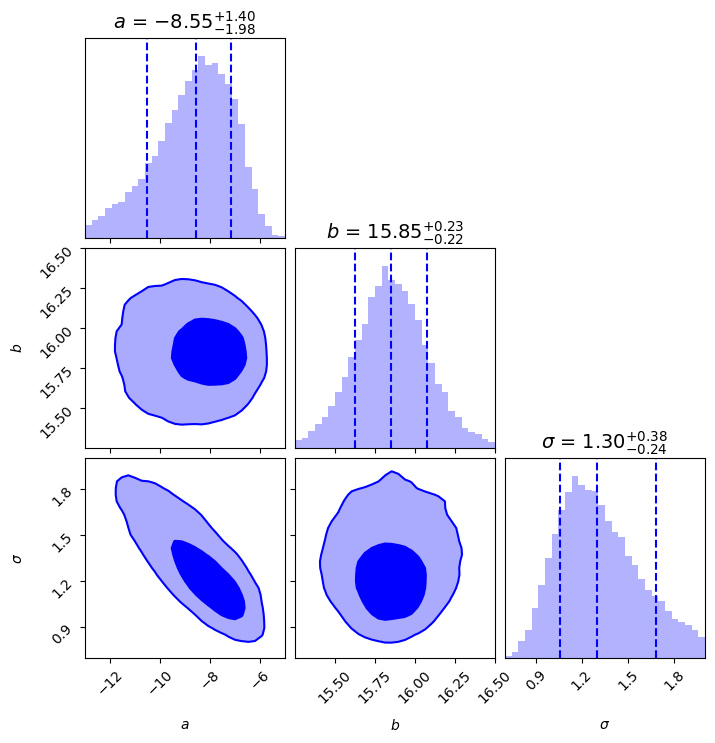

In [77]:
fig = corner.corner(mcmc_samples3.T, bins=30, smooth=1,
             range=[[-13, -5], [15.25, 16.5], [0.7, 2]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma'},
             title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

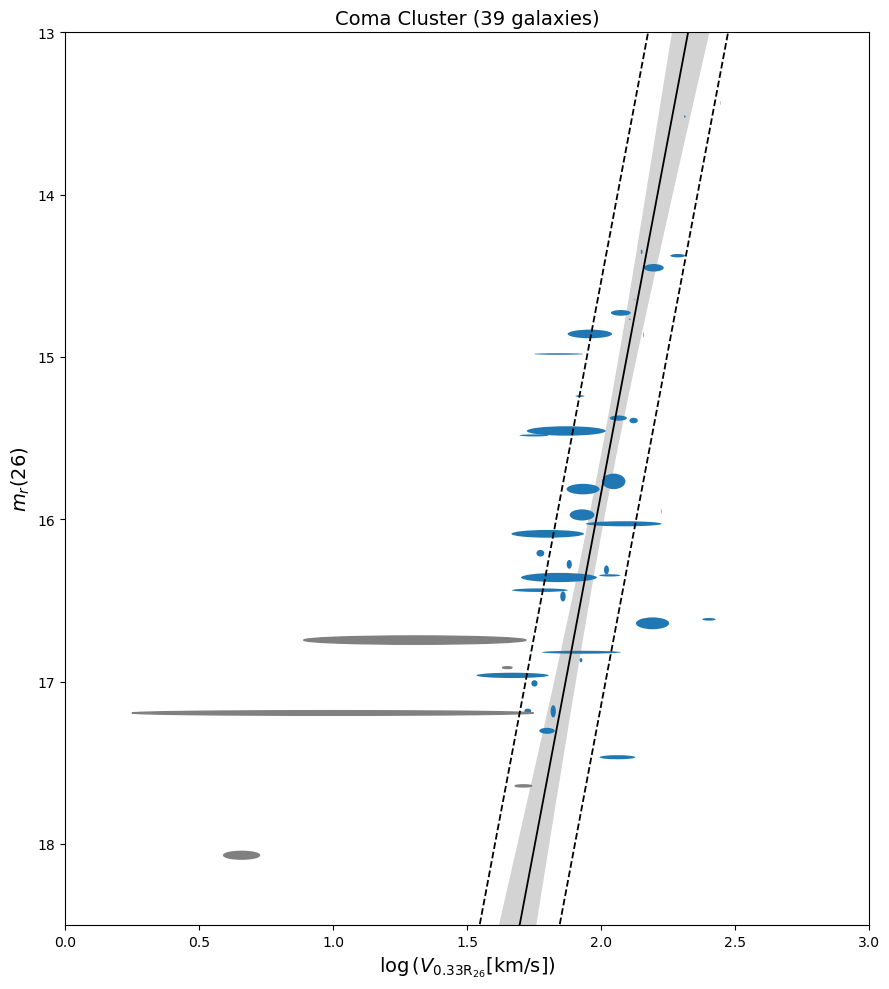

In [79]:
sigmas = hf.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = hf.coords[0] * (xvals - 2.) + hf.coords[1]

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals - 2., mcmc_samples3[0]) + mcmc_samples3[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF_bright3['V_0p33R26']), SGA_TF_bright3['R_MAG_SB26']]
x_err = 0.434*SGA_TF_bright3['V_0p33R26_err']/SGA_TF_bright3['V_0p33R26']
y_err = SGA_TF_bright3['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Removed galaxies
data_removed = [np.log10(SGA_TF['V_0p33R26'][dwarfs3]), SGA_TF['R_MAG_SB26'][dwarfs3]]
x_err_removed = 0.434*SGA_TF['V_0p33R26_err'][dwarfs3]/SGA_TF['V_0p33R26'][dwarfs3]
y_err_removed = SGA_TF['R_MAG_SB26_ERR'][dwarfs3]
corr_xy_removed = np.zeros_like(x_err_removed)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
ells_removed = [
    Ellipse(
        xy=[data_removed[0][i], data_removed[1][i]],
        width=2*y_err_removed[i],
        height=2*x_err_removed[i],
        angle=np.rad2deg(np.arccos(corr_xy_removed[i])),
    )
    for i in range(len(data_removed[0]))
]

# Make the plot
fig, ax = plt.subplots(figsize=(9,10), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    #e.set_color(cm.winter(sigmas[i] / np.amax(sigmas)))
    e.set_edgecolor('None')
    #e.set_alpha(0.9)
for i, e in enumerate(ells_removed):
    ax.add_artist(e)
    e.set_color('gray')
    #e.set_edgecolor('None')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF_bright3)), fontsize = 14)
ax.set_xlim(0, 3)
ax.set_ylim(18.5, 13);

#plt.savefig('../../Figures/SV/fuji_Coma_TFR_20221013.png', dpi=150)

### Fourth iteration

Using `dwarfs4` sample

#### Create covariance matrix for `hyperfit`

In [83]:
Ndata = len(SGA_TF_bright4)
cov = np.empty((2, 2, Ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i in range(Ndata):
    cov[:,:,i] = np.array([[(0.434*SGA_TF_bright4['V_0p33R26_err'][i]/SGA_TF_bright4['V_0p33R26'][i])**2, 0.], 
                           [0., SGA_TF_bright4['R_MAG_SB26_ERR'][i]**2]])

#### Create `hyperfit` object

In [84]:
hf = LinFit([np.log10(SGA_TF_bright4['V_0p33R26']) - 2., SGA_TF_bright4['R_MAG_SB26']], cov)

#### Run MCMC to fit TFR

In [85]:
bounds4 = ((-10.0, 10.0), (-1000.0, 1000.0), (1.0e-5, 500.0))

mcmc_samples4, mcmc_lnlike4 = hf.emcee(bounds4, verbose=True)

print(np.mean(mcmc_samples4, axis=1), np.std(mcmc_samples4, axis=1))

     fun: -50.31387763536259
     jac: array([ 0.01655422, -0.06870096,  0.00218705])
 message: 'Optimization terminated successfully.'
    nfev: 4708
     nit: 103
 success: True
       x: array([1.67106852, 0.17635771, 0.13733783])


100%|██████████| 1000/1000 [00:00<00:00, 2287.79it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [68.03920542 67.65975818 56.76266765] / 3401.960271198968


100%|██████████| 1000/1000 [00:00<00:00, 2208.41it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [107.67836055 105.98777517  54.35560747] / 5383.918027513124


100%|██████████| 1000/1000 [00:00<00:00, 2255.87it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [99.21502631 99.8540315  54.7632976 ] / 4992.701575069644


100%|██████████| 1000/1000 [00:00<00:00, 2264.49it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [99.72989946 96.97522597 51.59061647] / 4986.49497314253


100%|██████████| 1000/1000 [00:00<00:00, 2129.33it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [93.85713852 90.59504699 60.31451945] / 4692.856926131069


100%|██████████| 1000/1000 [00:00<00:00, 2263.62it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [140.79075159 136.45772038  55.8290806 ] / 7039.537579329211


100%|██████████| 1000/1000 [00:00<00:00, 2182.30it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [211.2779055  206.84383238  60.35692816] / 10563.895274848348


100%|██████████| 1000/1000 [00:00<00:00, 2249.69it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [189.14201095 186.83112337  65.72840228] / 9457.10054739703


100%|██████████| 1000/1000 [00:00<00:00, 2212.01it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [186.73530094 185.34296515  68.01870499] / 9336.765046842635


100%|██████████| 1000/1000 [00:00<00:00, 2260.85it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [190.88033796 192.79296215  62.86279957] / 9639.648107375633


100%|██████████| 1000/1000 [00:00<00:00, 2168.05it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [194.96101281 194.69588231  64.54452733] / 9748.050640358486
[-9.26552023 16.00471773  1.37514317] [2.10401192 0.26634535 0.36962178]


#### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and $m_r$, and the color given by the best-fit scatter parameter $\sigma_i$.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [99]:
a4, b4, sig4    = np.median(mcmc_samples4, axis=1)
da4, db4, dsig4 = np.std(mcmc_samples4, axis=1)

for val, err in zip((a4, b4, sig4), (da4, db4, dsig4)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -8.95 +/- 2.10
 15.99 +/- 0.27
  1.30 +/- 0.37


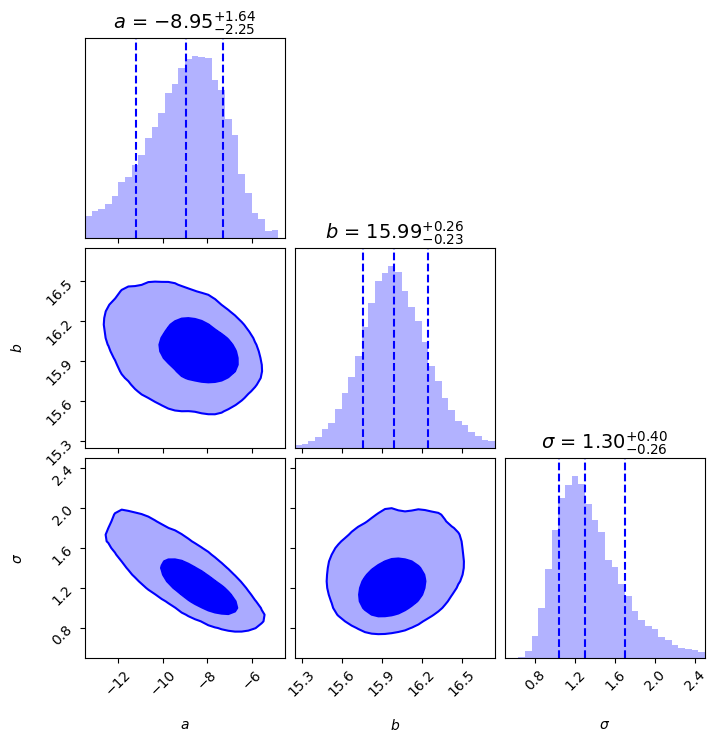

In [91]:
fig = corner.corner(mcmc_samples4.T, bins=30, smooth=1,
             range=[[-13.5, -4.5], [15.25, 16.75], [0.5, 2.5]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma'},
             title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

### Fifth iteration

Using `dwarfs5` sample

#### Create covariance matrix for `hyperfit`

In [103]:
Ndata = len(SGA_TF_bright5)
cov = np.empty((2, 2, Ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i in range(Ndata):
    cov[:,:,i] = np.array([[(0.434*SGA_TF_bright5['V_0p33R26_err'][i]/SGA_TF_bright5['V_0p33R26'][i])**2, 0.], 
                           [0., SGA_TF_bright5['R_MAG_SB26_ERR'][i]**2]])

#### Create `hyperfit` object

In [104]:
hf = LinFit([np.log10(SGA_TF_bright5['V_0p33R26']) - 2., SGA_TF_bright5['R_MAG_SB26']], cov)

#### Run MCMC to fit TFR

In [105]:
bounds5 = ((-10.0, 10.0), (-1000.0, 1000.0), (1.0e-5, 500.0))

mcmc_samples5, mcmc_lnlike5 = hf.emcee(bounds5, verbose=True)

print(np.mean(mcmc_samples5, axis=1), np.std(mcmc_samples5, axis=1))

     fun: -48.68105983796883
     jac: array([ 0.00243858,  0.0049468 , -0.00932729])
 message: 'Optimization terminated successfully.'
    nfev: 7040
     nit: 155
 success: True
       x: array([1.5517684 , 0.1503824 , 0.13236643])


100%|██████████| 1000/1000 [00:00<00:00, 2285.22it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [64.31885899 64.59977796 45.57150876] / 3229.988898242772


100%|██████████| 1000/1000 [00:00<00:00, 2199.47it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [110.86030481 110.71432671  53.75784727] / 5543.0152407348305


100%|██████████| 1000/1000 [00:00<00:00, 2301.37it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [149.75172659 145.96174543  52.3873728 ] / 7487.5863292956765


100%|██████████| 1000/1000 [00:00<00:00, 2203.46it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [156.71015617 156.50587747  60.11999205] / 7835.507808636918


100%|██████████| 1000/1000 [00:00<00:00, 2349.13it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [182.21271785 179.59944327  64.71414446] / 9110.635892690509


100%|██████████| 1000/1000 [00:00<00:00, 2230.75it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [195.08892902 191.15233048  68.59877375] / 9754.44645093459


100%|██████████| 1000/1000 [00:00<00:00, 2269.60it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [173.28945113 174.59022251  63.56440374] / 8729.511125391793


100%|██████████| 1000/1000 [00:00<00:00, 2179.16it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [229.50231831 228.18389845  66.87361421] / 11475.115915346169


100%|██████████| 1000/1000 [00:00<00:00, 2219.40it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [217.50653647 215.71407385  65.71647347] / 10875.326823540241


100%|██████████| 1000/1000 [00:00<00:00, 2317.25it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [263.15422925 255.5412686   66.30916608] / 13157.711462743031


100%|██████████| 1000/1000 [00:00<00:00, 2148.58it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [281.2414003  273.71332018  65.69520555] / 14062.070014865447


100%|██████████| 1000/1000 [00:00<00:00, 2174.32it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [286.55393768 280.30472568  68.8496102 ] / 14327.696883963261


100%|██████████| 1000/1000 [00:00<00:00, 2246.23it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [273.43631091 265.30683448  64.83661488] / 13671.815545261783


100%|██████████| 1000/1000 [00:00<00:00, 2234.31it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [253.04379252 248.33811786  66.79385299] / 12652.189626087258


100%|██████████| 1000/1000 [00:00<00:00, 2137.61it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [240.70829715 232.88105289  66.11153072] / 12035.414857543921


100%|██████████| 1000/1000 [00:00<00:00, 2177.60it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [235.91006904 227.9287405   67.4460321 ] / 11795.503451821307
[-10.25240964  16.15874964   1.47558952] [2.82324216 0.32166154 0.47033494]


#### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and $m_r$, and the color given by the best-fit scatter parameter $\sigma_i$.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [106]:
a5, b5, sig5    = np.median(mcmc_samples5, axis=1)
da5, db5, dsig5 = np.std(mcmc_samples5, axis=1)

for val, err in zip((a5, b5, sig5), (da5, db5, dsig5)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -9.68 +/- 2.82
 16.13 +/- 0.32
  1.37 +/- 0.47


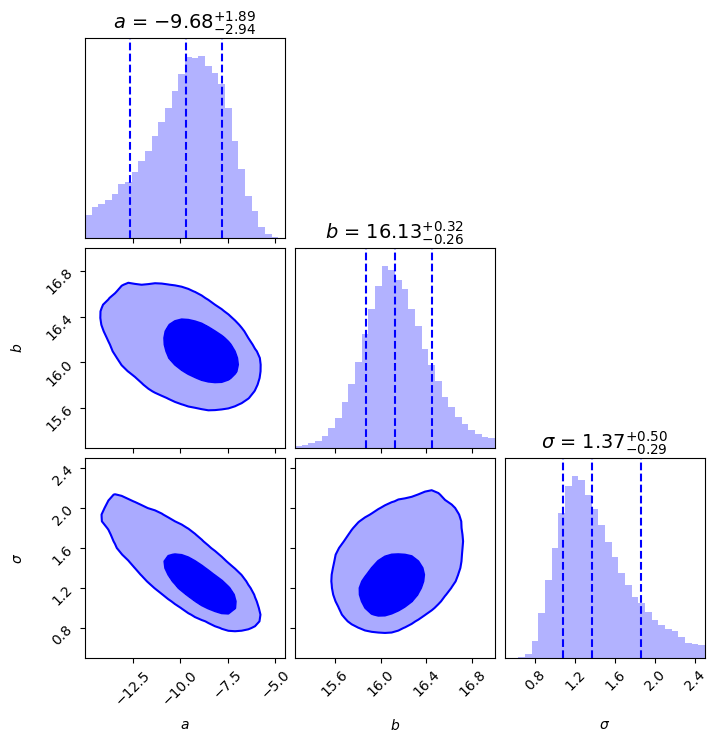

In [110]:
fig = corner.corner(mcmc_samples5.T, bins=30, smooth=1,
             range=[[-15, -4.5], [15.25, 17], [0.5, 2.5]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma'},
             title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)